# Figure 1: Estimation of Diffusion and Permittivity in Dendritic Spines
Because of their small size biophysical parameters can hardly be measured in dendritic spines. We use a method called homogenization to estimate diffusion coefficients and the electrical permittivity inside dendritic spines based on experimental measurements in dilute solutions and based on the strucutre of the intracellular space in spines.

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import importlib

import plot_functions as pf

## load image of spine (H11 layer 110)

-0.24491866 0.93175876
aspect ratio of image array:  2.3466257668711656


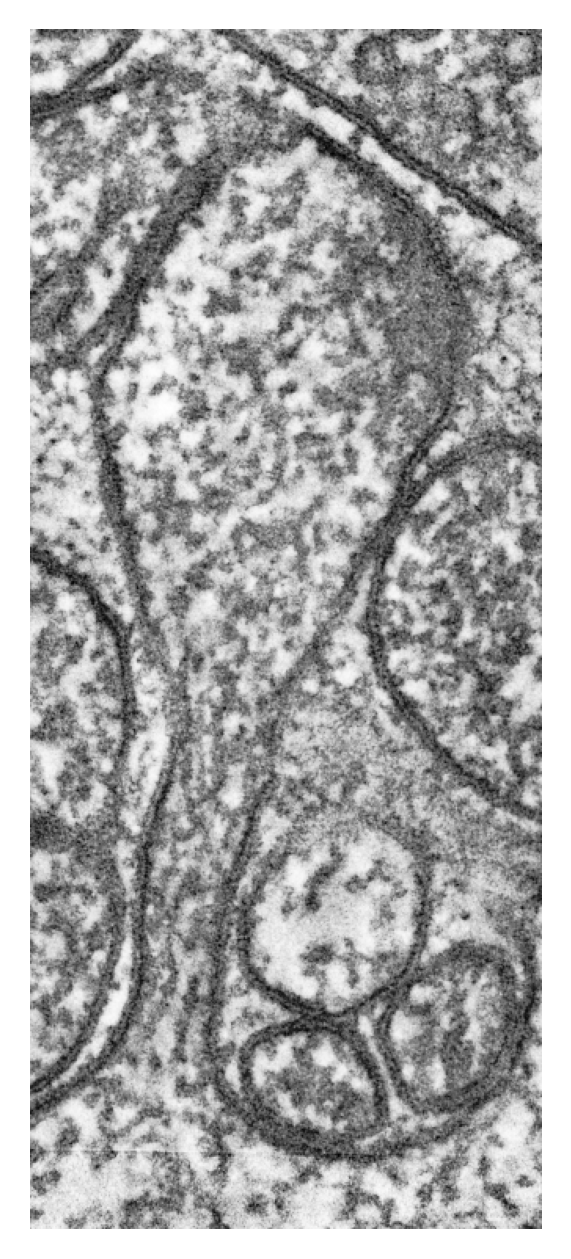

In [4]:
def spine_image(fig, pos):

    spine_img = plt.imread('./../Fig_homogenization_methods/H11_layer110.png')

    spine_img = np.tanh( (spine_img - 0.1) * 2.5)
    spine_img = np.flipud(spine_img)
    spine_img = spine_img[235:,349:675]

    print(np.min(spine_img), np.max(spine_img))
    print('aspect ratio of image array: ', np.shape(spine_img)[0] / np.shape(spine_img)[1])
    
    ax = fig.add_axes(pos)
    ax.imshow(spine_img, cmap='Greys')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig = plt.figure(dpi=300)
spine_image(fig, [0,0,1,1])
#2.3468531468531473

### load raw actin data

In [5]:
raw_data = pickle.load(open('./../Fig_homogenization_methods/C1_k01_head_25_102_raw.pcl', 'rb'))
np.shape(raw_data)

(235, 348, 78)

(150, 210)


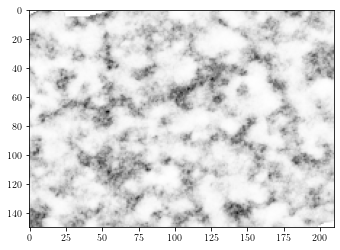

In [6]:
raw_img = raw_data[65:-20,25:-113,70]
print(np.shape(raw_img))
plt.imshow(raw_img, cmap='Greys')
plt.savefig('./../Fig_homogenization_methods/raw_image.png')

### load reference cell image

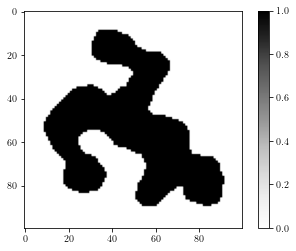

In [7]:
def rgb2gray(rgb_img):
    
    gray_img = 0.2125 * rgb_img[:,:,0] + 0.7154 * rgb_img[:,:,1] + 0.0721 * rgb_img[:,:,2]
    return gray_img
ref_cell = plt.imread('./../Fig_homogenization_methods/reference_cell.png')
ref_cell = rgb2gray(ref_cell)
ref_cell[np.where(ref_cell > 0.)] = 1.
ref_cell[np.where(ref_cell == 0.)] = 2.
ref_cell -= 1.

plt.imshow(ref_cell, cmap='Greys')
plt.colorbar()

### subplots

In [8]:
def ax_raw_data(fig, pos, img):
    ax = fig.add_axes(pos)
    
    img = np.tanh(img)
    ax.imshow(img, cmap='Greys')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title('Heterogenous\nintracellular space', fontsize=8)
    
def ax_periodic(fig, pos, ref_cell):
    ax = fig.add_axes(pos)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Periodic \nbiphasic geometry', fontsize=8)
    
    nx = 7
    ny = 5
    xw = pos[2] / nx
    yw = pos[3] / ny
    x0 = pos[0]
    y0 = pos[1]
    
    for xi in range(7):
        for yi in range(5):
            ax = fig.add_axes([x0+xi*xw, y0+yi*yw, xw, yw])
            ax.imshow(ref_cell, cmap='Greys')
            ax.set_xticks([])
            ax.set_yticks([])
            
    
            
def ax_homogenized(fig, pos, color='dimgrey'):
    ax = fig.add_axes(pos)
    ax.fill_between([0.,1.],[0.,0.], [1.,1.], color=color, lw=0.)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0.,1.])
    ax.set_ylim([0.,1.])
    ax.set_title('Homogeneous \n approximation', fontsize=8)


def straigth_filament_voxels(x,y,z,diameter):  
    n = np.shape(x)[0]
    s = 0.5 * diameter  # scale parameter
    voxels = (x >= (0.5*n-s)) & (x < (0.5*n+s)) & (y >= (0.5*n-s)) & (y < (0.5*n+s))
    return voxels

def crossing_filement_voxels(x,y,z,diameter):  
    n = np.shape(x)[0]
    s = 0.5 * diameter  # scale parameter
    zfil = (x >= (0.5*n-s)) & (x < (0.5*n+s)) & (y >= (0.5*n-s)) & (y < (0.5*n+s))
    xfil = (z >= (0.5*n-s)) & (z < (0.5*n+s)) & (y >= (0.5*n-s)) & (y < (0.5*n+s))
    yfil = (x >= (0.5*n-s)) & (x < (0.5*n+s)) & (z >= (0.5*n-s)) & (z < (0.5*n+s))
    voxels = xfil | yfil | zfil
    return voxels
    
def actin_mesh_voxles(x,y,z,diameter):  
    n = np.shape(x)[0]
    s = 0.5 * diameter  # scale parameter
    zfil = (x >= (0.5*n-s)) & (x < (0.5*n+s)) & (y >= (0.5*n-s)) & (y < (0.5*n+s))
    xfil = (z >= (0.5*n-s)) & (z < (0.5*n+s)) & (y >= (0.5*n-s)) & (y < (0.5*n+s))
    yfil = (x >= (0.5*n-s)) & (x < (0.5*n+s)) & (z >= (0.5*n-s)) & (z < (0.5*n+s))
    voxels = xfil | yfil | zfil
    
    # boxes in corners
    d = diameter  
    boxes = [
        (x < s) & (y < s) & (z < s),
        (x < s) & (y < s) & (z >= (n - s)),
        
        (x >= (n - s)) & (y < s) & (z < s),
        (x < s) & (y >= (n - s)) & (z < s),
        (x >= (n - s)) & (y >= (n - s)) & (z < s),
        (x >= (n - s)) & (y < s) & (z >= (n - s)),
        (x < s) & (y >= (n - s)) & (z >= (n - s)),
        (x >= (n - s)) & (y >= (n - s)) & (z >= (n - s)),
    ]
    for box in boxes:
        voxels = voxels | box
    
    return voxels 

    
def ax_3d_ref_cell(fig, pos, geometry='straight', diameter=8.):
    
    ax = fig.add_axes(pos, projection='3d')
    
    # prepare some coordinates
    n = 32
    x, y, z = np.indices((n, n, n))
    
    if geometry == 'straight':
        voxels = straigth_filament_voxels(x, y, z, diameter)
    elif geometry == 'crossing':
        voxels = crossing_filement_voxels(x, y, z, diameter)
    elif geometry == 'actin':
        voxels = actin_mesh_voxles(x, y, z, diameter)
    
    # set the colors of each object
    colors = np.empty(voxels.shape, dtype=object)
    colors[voxels] = 'dimgrey'
    
    ax.voxels(voxels, facecolors=colors, edgecolor='none')
    
    s = 2
    ax.set_xlim([0-s,n+s])
    ax.set_ylim([0-s,n+s])
    ax.set_zlim([0,n])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_aspect(aspect='auto', anchor='C')
    


### Figure

wy2 0.3693333333333333
Figure A - spine image
aspact ratio of axis(width/height):  2.4213564213564216
-0.24491866 0.93175876
aspect ratio of image array:  2.3466257668711656


findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


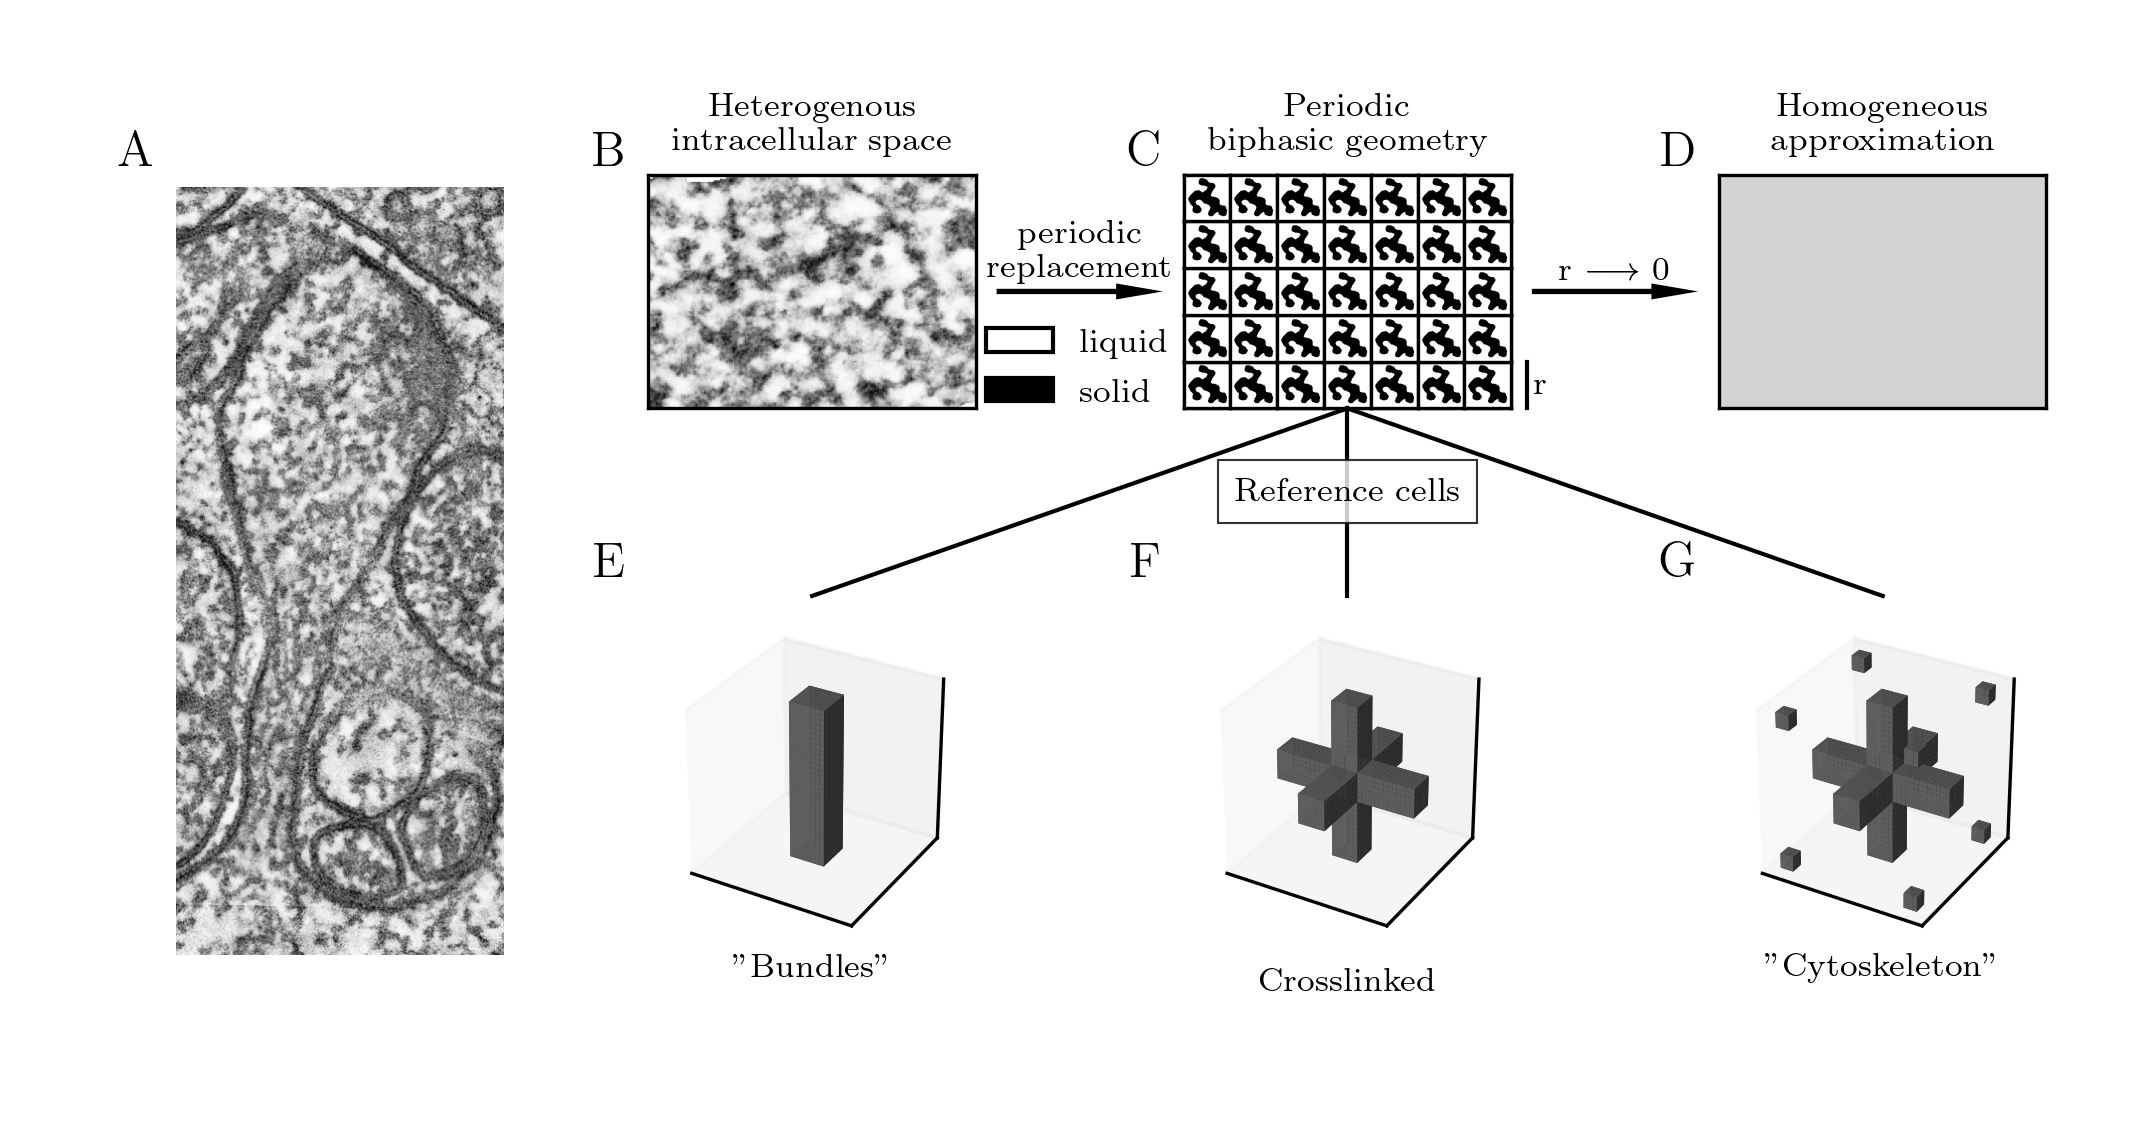

In [9]:
###########################
# set figure size

fig_width = 17.6 / 2.54 # cm / (cm to inch)
fig_height = 9.0 / 2.54
aspect_ratio = fig_width / fig_height

# set relative x positions of axes
marg_left = 0.07
marg_right = 0.03
whitespace_v = 0.1
wx = (1. - 2 * marg_left - marg_right - 2* whitespace_v) /4. # width of subfigures
px1 = marg_left
px2 = px1 + wx + marg_left
px3 = px2 + wx + whitespace_v
px4 = px3 + wx + whitespace_v

# set relative y positions of axes
marg_bottom = 0.06 * aspect_ratio
marg_top = 0.07 * aspect_ratio
whitespace_h = 0.08 * aspect_ratio
wy3 = wx * 5. / 7. * aspect_ratio # height of homogenization explanation
wy2 = 1. - marg_bottom - whitespace_h - marg_top - wy3 # hight of reference cells
wy1 = 1. -  marg_bottom - marg_top # height of spine image
py1 = marg_bottom
py2 = py1 + wy2 + whitespace_h

### debug: 
##total_height = py2 + wy3 + marg_top
##total_width = px4 + wx + marg_right
##print('axis width:', wx, wy1, wy2, wy3)
print('wy2', wy2)

################################
# create figure
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

#################################
# plot spine
print('Figure A - spine image')
print('aspact ratio of axis(width/height): ', wy1/ wx / aspect_ratio)
posA = [px1, py1, wx, wy1]
spine_image(fig, posA)

##################################
# plot homogenization comic
posB = [px2, py2, wx, wy3]
ax_raw_data(fig, posB, img=raw_img)

posC = [px3, py2, wx, wy3]
ax_periodic(fig, posC, ref_cell)

posD = [px4, py2, wx, wy3]
ax_homogenized(fig, posD, color='lightgrey')

##################################
# plot reference cells

posE = [px2, py1+0.02, wx, wy2-0.06]
ax_3d_ref_cell(fig, posE, geometry='straight')

posF = [px3, py1+0.02, wx, wy2-0.06]
ax_3d_ref_cell(fig, posF, geometry='crossing', diameter=6)

posG = [px4, py1+0.02, wx, wy2-0.06]
ax_3d_ref_cell(fig, posG, geometry='actin', diameter=6)

#######################################
## annotation

# create new axes to draw annotation
ax_annotate = fig.add_axes([0.,0.,1.,1.], zorder=10)
ax_annotate.set_facecolor('none')
ax_annotate.set_xticks([])
ax_annotate.set_yticks([])
ax_annotate.set_xlim([0.,1.])
ax_annotate.set_ylim([0.,1.])
ax_annotate.spines['right'].set_visible(False)
ax_annotate.spines['left'].set_visible(False)
ax_annotate.spines['top'].set_visible(False)
ax_annotate.spines['bottom'].set_visible(False)

#################################
# two arrows between homogenization explanation comics axes
m = 0.01 # arrow margin from axes
ax_annotate.arrow(px3 - whitespace_v +m,  
                  py2 + wy3/2 , 
                  whitespace_v-2*m, 
                  0,
                  length_includes_head=True, 
                  width=0.005, 
                  fc='k', 
                  ec='none')
ax_annotate.arrow(px4 - whitespace_v +m,  
                  py2 + wy3/2 , 
                  whitespace_v-2*m, 
                  0,
                  length_includes_head=True, 
                  width=0.005, 
                  fc='k', 
                  ec='none')

ax_annotate.text(
        px3 - 0.5*whitespace_v,  
        py2 + wy3/2*1.07 , 
        'periodic\n replacement', 
        fontsize=8, verticalalignment='bottom', horizontalalignment='center')

ax_annotate.text(
        px4 - 0.5*whitespace_v,  
        py2 + wy3/2*1.07 , 
        r'r $\longrightarrow$ 0', 
        fontsize=8, verticalalignment='bottom', horizontalalignment='center')

############################################

# periodic geometry legend
white_patch = mpatches.Patch(facecolor='white', label='liquid', edgecolor='black')
black_patch = mpatches.Patch(color='black', label='solid')
fig.legend(handles=[white_patch, black_patch], 
           loc=(px3 - whitespace_v,  
           py2 - 0.019),
           fontsize=8,
           frameon=False,
          )

#scale of periodic geometry
ax_annotate.plot([px3 + 1.05*wx, px3 + 1.05*wx],[py2, py2 + wy3/5.],
       lw = 1. , c='k' )
ax_annotate.text(
         px3 + 1.07*wx, 
         py2 + wy3/10.,
        'r', 
        fontsize=8, verticalalignment='center', horizontalalignment='left')
#################################
# arrows from periodic structure to reference cells

ax_annotate.text(
px3 + 0.5*wx,
py2 - 0.5 * whitespace_h,
'Reference cells',
fontsize=8, verticalalignment='center', horizontalalignment='center', 
    bbox=dict(facecolor='white', alpha=0.8, linewidth=.5))


xarrow = px3 + 0.5*wx
yarrow = py2
dx = whitespace_v + wx
dy = whitespace_h + 0.02
lw=1.

ax_annotate.plot([xarrow, xarrow],
                 [yarrow, yarrow - dy],
                 lw = lw , c='k' 
                 )
ax_annotate.plot([xarrow, xarrow + dx],
                 [yarrow, yarrow - dy],
                 lw = lw , c='k' 
                 )
ax_annotate.plot([xarrow, xarrow -dx],
                 [yarrow, yarrow - dy],
                 lw = lw , c='k' 
                 )

#############################
# label for reference cells

ax_annotate.text(
px3 + 0.5*wx,
marg_bottom,
"Crosslinked",
fontsize=8, verticalalignment='top', horizontalalignment='center')

ax_annotate.text(
px2 + 0.5*wx,
marg_bottom,
'"Bundles"',
fontsize=8, verticalalignment='center', horizontalalignment='center')

ax_annotate.text(
px4 + 0.5*wx,
marg_bottom,
'"Cytoskeleton"',
fontsize=8, verticalalignment='center', horizontalalignment='center')


##################################
x_shift = 0.01
fig.text(px1 - x_shift, py1 + wy1,  
         'A', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px2 - x_shift, py2 + wy3, 
         'B', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px3 - x_shift, py2 + wy3, 
         'C', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px4 - x_shift, py2 + wy3, 
         'D', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px2 - x_shift, py1 + wy2 - x_shift, 
         'E', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px3 - x_shift, py1 + wy2 - x_shift, 
         'F', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')
fig.text(px4 - x_shift, py1 + wy2 - x_shift, 
         'G', fontsize=12,  verticalalignment='bottom', horizontalalignment='right')

######################
plt.savefig('./../../../PaperSpineElectrodiffusion/figures/Figure01_part1.tif')
plt.show()

width 6.929133858267717
wy2 0.3693333333333333
Cuboid geometry: 
por, diff, per1, per2: 0.9374999999997271, 0.8704377750867409,0.870822930820247,0.8839586223098009
por, diff, per1, per2: 0.7500000000030661, 0.5763210058342989,0.5793456160001393,0.6075169974258161
por, diff, per1, per2: 0.4374999999982265, 0.2678765082095467,0.2664704466516553,0.28847246068473886
por, diff, per1, per2: 0.959999999999788, 0.9148257478258522,0.9145635036185937,0.9237495547049739
por, diff, per1, per2: 0.8399999999991523, 0.7033651983919732,0.7059045488973273,0.7298338479275317
por, diff, per1, per2: 0.6399999999980927, 0.4491279985164256,0.4519682192067788,0.480187989020042
por, diff, per1, per2: 0.3599999999993028, 0.21117507486297402,0.20828398906082968,0.22676769006935757
por, diff, per1, per2: 0.9722222222225629, 0.9401925080166905,0.9398870116887003,0.9464857435498372
por, diff, per1, per2: 0.8888888888902516, 0.7834862985918002,0.7854829061163449,0.8046766696084746
por, diff, per1, per2: 0.555555555

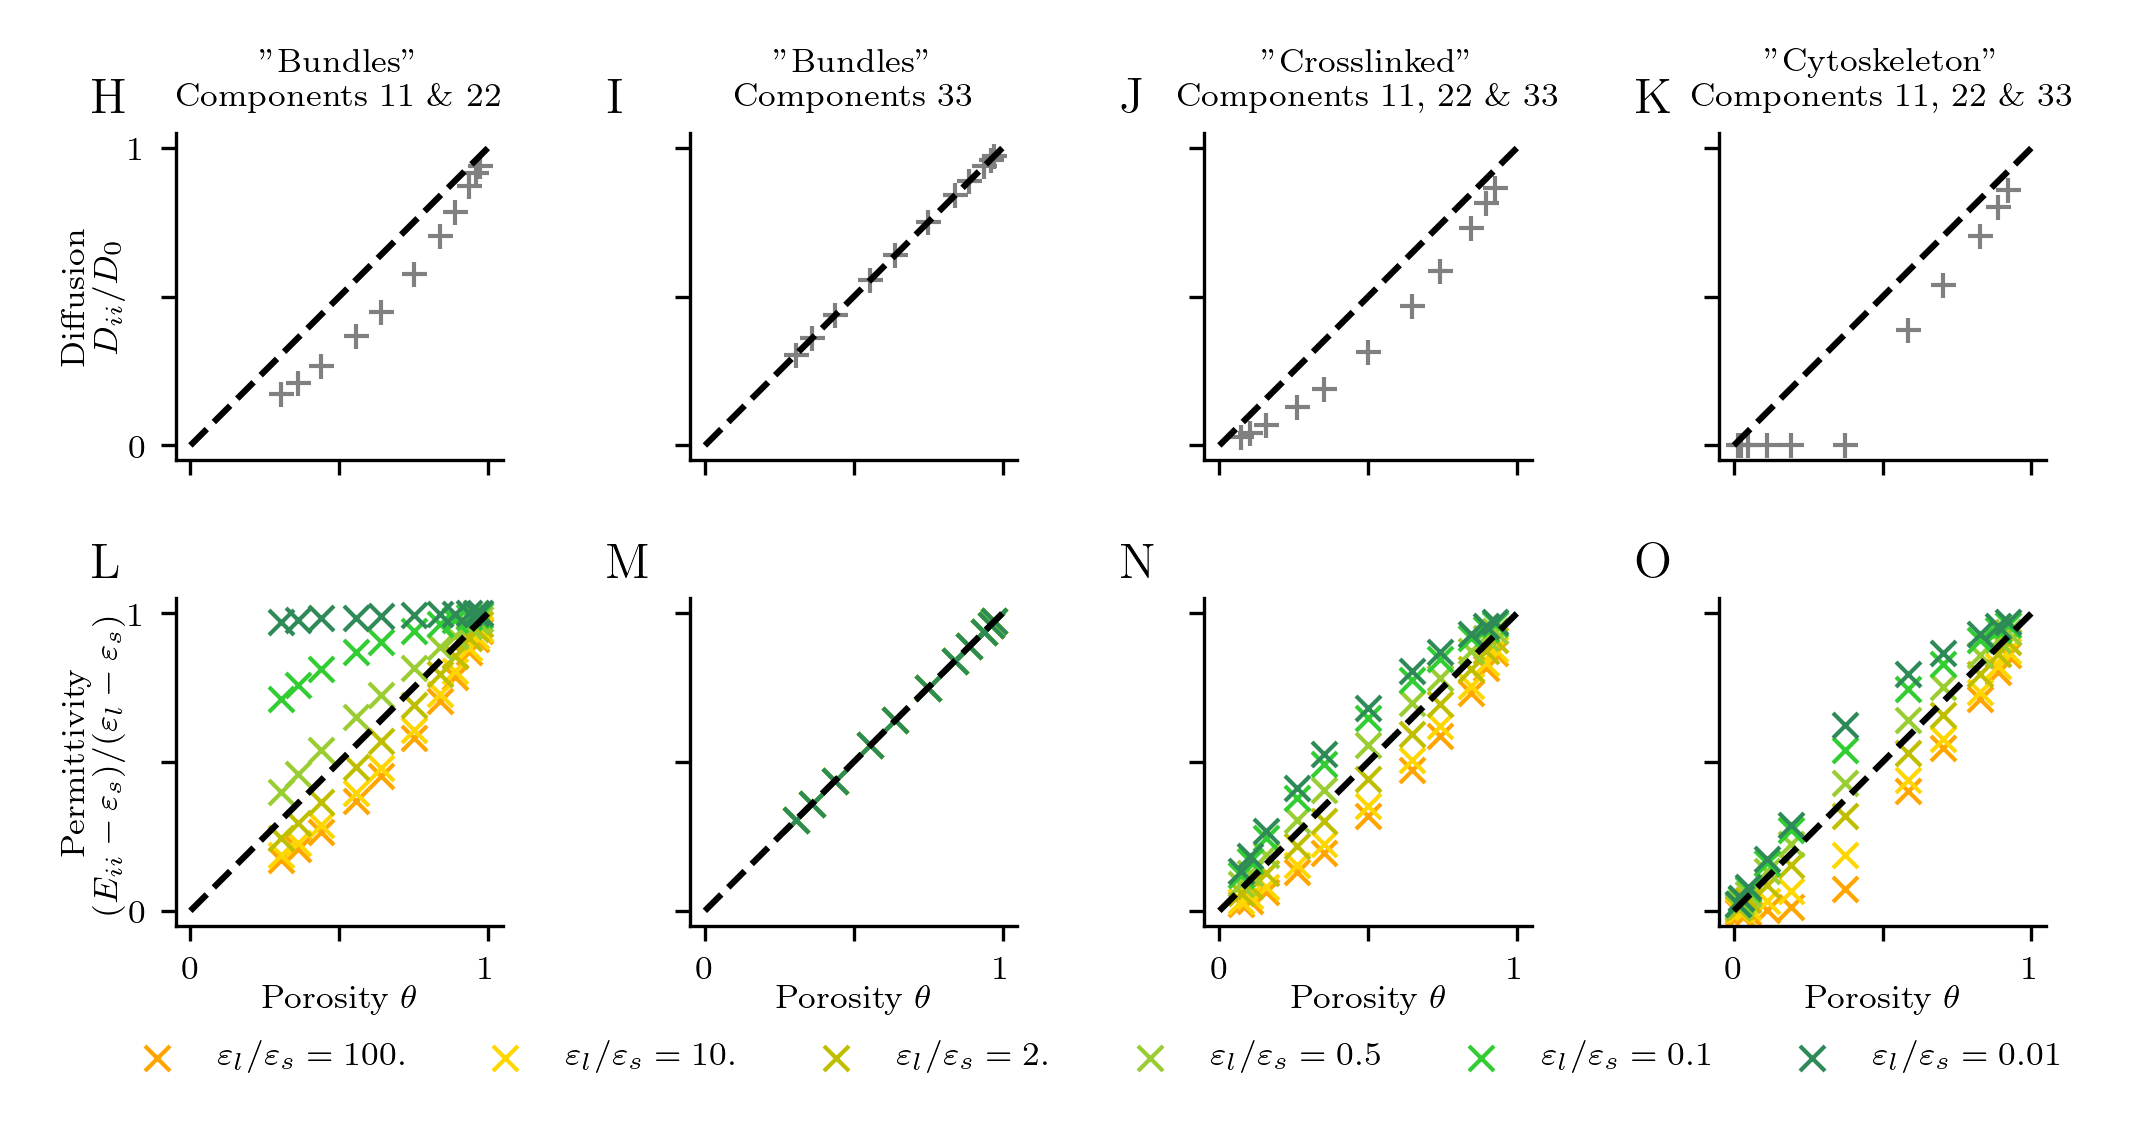

In [11]:
importlib.reload(pf)
colors = [ 'orange', 'gold','y', 'yellowgreen', 'limegreen', 'seagreen']

fig_width = 17.6 / 2.54 # cm / (cm to inch)
print('width', fig_width)


# set relative x positions of axes
marg_left = 0.07
marg_right = 0.03
whitespace_v = 0.09
wx = (1. - marg_left - marg_right - 3* whitespace_v) /4. # width of subfigures
px1 = marg_left
px2 = px1 + wx + whitespace_v
px3 = px2 + wx + whitespace_v
px4 = px3 + wx + whitespace_v


fig_height = 9.0 / 2.54
aspect_ratio = fig_width / fig_height
# set relative y positions of axes
marg_bottom = 0.08 * aspect_ratio
marg_top = 0.055 * aspect_ratio
whitespace_h = 0.035 * aspect_ratio
wy = wx * aspect_ratio # height of homogenization explanation
py1 = marg_bottom
py2 = py1 + wy2 + whitespace_h


### debug: 
##total_height = py2 + wy3 + marg_top
##total_width = px4 + wx + marg_right
##print('axis width:', wx, wy1, wy2, wy3)
print('wy2', wy2)

################################
# create figure
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)

###############################
# bundles D11&22
pos11 = [px1, py1, wx, wy]
pos12 = [px1, py2, wx, wy]

gm = 'extended_box_3d'
plot_data = pickle.load(open('./../results/plot_data_extended_box_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig, pos11, pos12, 
                                        x_data, y_data_1, x_data, y_data_2, 
                                       colors=colors,
                                       leg_loc=(-0.2, -0.5))

##############################
# bundles D33
pos21 = [px2, py1, wx, wy]
pos22 = [px2, py2, wx, wy]

gm = 'extended_box_3d'
plot_data = pickle.load(open('./../results/plot_data_extended_box_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig, pos21, pos22, 
                                        x_data, x_data, x_data, x_data, 
                                       make_ylabel=False, colors=colors,
                                       )

print('Cuboid geometry: ')
for por,dif,per1,per2 in zip(x_data[0], y_data_1[0], y_data_2[0], y_data_2[1]):
    print('por, diff, per1, per2: {por}, {dif},{per1},{per2}'.format(por=por,dif=dif, per1=per1, per2=per2))
    
##############################
# Crosslinked 
pos31 = [px3, py1, wx, wy]
pos32 = [px3, py2, wx, wy]

gm = 'crossing_filaments_3d'
plot_data = pickle.load(open('./../results/plot_data_crossing_filaments_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

print('Crosslinked geometry: ')
for por,dif,per1,per2 in zip(x_data[0], y_data_1[0], y_data_2[0], y_data_2[1]):
    print('por, diff, per1, per2: {por}, {dif},{per1},{per2}'.format(por=por,dif=dif, per1=per1, per2=per2))

pf.plot_pourosity_vs_correction_tensors(fig, pos31, pos32, 
                                         x_data, y_data_1, x_data, y_data_2, 
                                      make_ylabel=False, colors=colors,
                                       )
##############################
# Actin
pos41 = [px4, py1, wx, wy]
pos42 = [px4, py2, wx, wy]

gm = 'actin_cytosceleton_3d'
plot_data = pickle.load(open('./../results/plot_data_actin_cytosceleton_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

print('Cytoskeleton geometry: ')
for por,dif,per1,per2 in zip(x_data[0], y_data_1[0], y_data_2[0], y_data_2[1]):
    print('por, diff, per1, per2: {por}, {dif},{per1},{per2}'.format(por=por,dif=dif, per1=per1, per2=per2))


pf.plot_pourosity_vs_correction_tensors(fig, pos41, pos42, 
                                         x_data, y_data_1, x_data, y_data_2, 
                                      make_ylabel=False, colors=colors,)

##################
ax_label = fig.add_axes([0.,0.,1.,1.])
ax_label.set_facecolor('none')
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.spines['top'].set_visible(False)
ax_label.spines['right'].set_visible(False)
ax_label.spines['left'].set_visible(False)
ax_label.spines['bottom'].set_visible(False)

ax_label.text(0.015, py2 + 0.5 * wy, 'Diffusion', 
             verticalalignment='center', horizontalalignment='left', rotation=90, fontsize=8)

ax_label.text(0.015, py1 + 0.5 * wy, 'Permittivity', 
             verticalalignment='center', horizontalalignment='left', rotation=90, fontsize=8)

x_tmp = px1 + 0.5 * wx
y_tmp = py2 + wy + 0.08
ax_label.text(x_tmp, y_tmp, 
              '"Bundles"\nComponents 11 \& 22',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )

    
x_tmp = px2 + 0.5 * wx
ax_label.text(x_tmp, y_tmp, 
              '"Bundles"\n Components 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )
#ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 33',
#            verticalalignment='top', horizontalalignment='center', fontsize=8 )

x_tmp = px3 + 0.5 * wx
ax_label.text(x_tmp, y_tmp, 
              '"Crosslinked"\n Components 11, 22 \& 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )
#ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 11, 22 \& 33',
#            verticalalignment='top', horizontalalignment='center', fontsize=8 )

x_tmp = px4 + 0.5 * wx
ax_label.text(x_tmp, y_tmp, 
              '"Cytoskeleton"\n Components 11, 22 \& 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )
#ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 11, 22 \& 33',
#            verticalalignment='top', horizontalalignment='center', fontsize=8 )

shift_x, shift_y = -0.04, 0.02
fig.text(pos12[0]+shift_x,pos12[1]+pos12[3]+shift_y,'H', fontsize=12)
fig.text(pos22[0]+shift_x,pos22[1]+pos22[3]+shift_y,'I', fontsize=12)
fig.text(pos32[0]+shift_x,pos32[1]+pos32[3]+shift_y,'J', fontsize=12)
fig.text(pos42[0]+shift_x,pos42[1]+pos42[3]+shift_y,'K', fontsize=12)
fig.text(pos11[0]+shift_x,pos11[1]+pos11[3]+shift_y,'L', fontsize=12)
fig.text(pos21[0]+shift_x,pos21[1]+pos21[3]+shift_y,'M', fontsize=12)
fig.text(pos31[0]+shift_x,pos31[1]+pos31[3]+shift_y,'N', fontsize=12)
fig.text(pos41[0]+shift_x,pos41[1]+pos41[3]+shift_y,'O', fontsize=12)

#############
plt.savefig('./../../../PaperSpineElectrodiffusion/figures/Figure01_part2.tif')



plt.show()

In [16]:
print('Cytoskeleton geometry: ')
for por,dif,per1,per2 in zip(x_data[0], y_data_1[0], y_data_2[0], y_data_2[1]):
    print('por, diff, per1, per2: {por}, {dif},{per1},{per2}'.format(por=por,dif=dif, per1=per1, per2=per2))

Actin geometry: 
[0.8281249999992497, 0.37500000000052025, 0.04687499999986784, 0.8879999999994066, 0.583999999998045, 0.19199999999963838, 0.023999999999952247, 0.9212962962972615, 0.7037037037073376, 0.11111111111137575, 0.013888888888920495] [0.7048429116105397, 1.5497391480155071e-06, 2.3774778296245e-07, 0.8006373914355208, 0.38922376033135986, 7.477920594031983e-07, 9.357842992305204e-08, 0.8582160131500894, 0.5378540379171893, 4.3275003438092784e-07, 5.415418398368568e-08] []
por, diff, per1, per2: 0.8281249999992497, 0.7048429116105397,0.7110957433880327,0.7355694658908337
por, diff, per1, per2: 0.37500000000052025, 1.5497391480155071e-06,0.07422640429709927,0.18721650772656323
por, diff, per1, per2: 0.04687499999986784, 2.3774778296245e-07,-0.004495387450825371,0.011574262487529982
por, diff, per1, per2: 0.8879999999994066, 0.8006373914355208,0.8032274931599566,0.821297563382244
por, diff, per1, per2: 0.583999999998045, 0.38922376033135986,0.4034234236550531,0.4399697082101514

In [18]:
# reduction of diffusion for 20 % volume reduction
0.5378540379171893 + (0.7048429116105397- 0.5378540379171893)*(0.8 - 0.7037037037073376)/(0.8281249999992497 - 0.7037037037073376) 

0.6670956592311617

In [19]:
# reduction of permittivity for 20 % volume reduction
0.5777188688366893 + (0.7355694658908337- 0.5777188688366893)*(0.8 - 0.7037037037073376)/(0.8281249999992497 - 0.7037037037073376) 

0.6998878890680567

0.1922727272727273 0.3052498646942089
[0.10102272727272726, 0.11455890312105357, 0.1922727272727273, 0.3052498646942089] [0.10102272727272726, 0.46563232906368396, 0.1922727272727273, 0.3052498646942089]


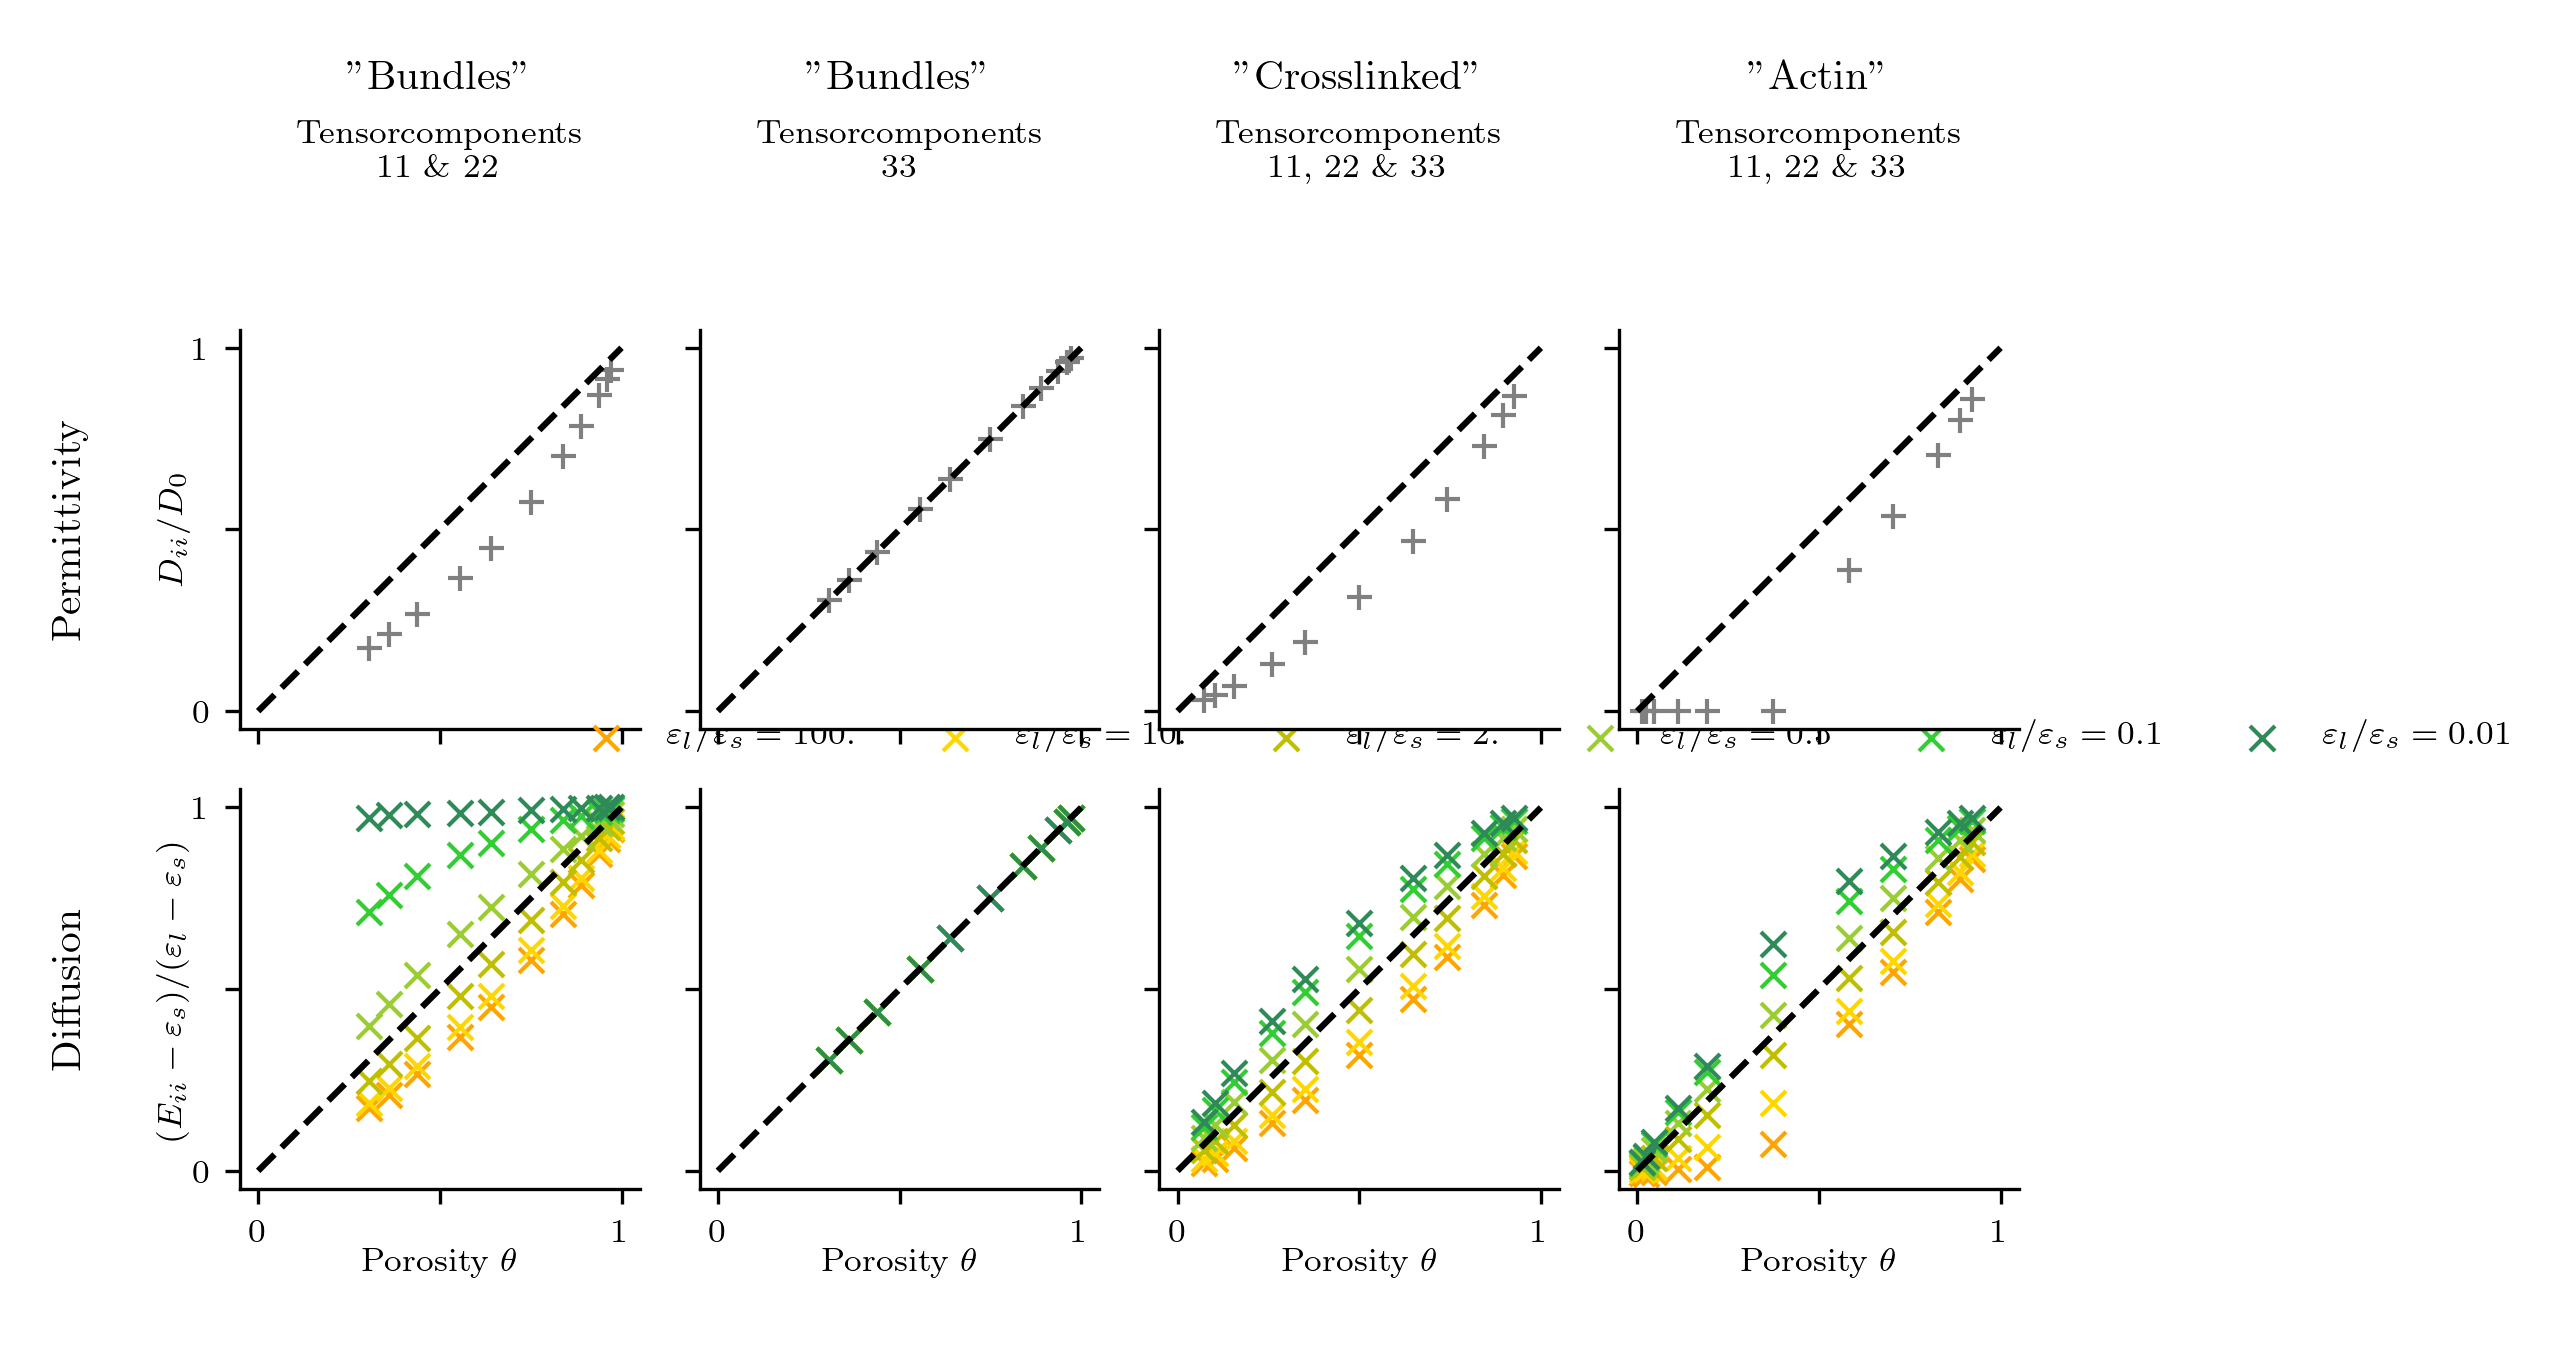

In [26]:
importlib.reload(pf)

colors = [ 'orange', 'gold','y', 'yellowgreen', 'limegreen', 'seagreen']


fig_width = 17.6 / 2.54 # cm / (cm to inch)


margin_left = 0.7
margin_right = 0.3
margin_top = 1.0 
margin_bottom = 0.5
margin_c = 0.2 
margin_l = 0.2 

dx_abs = (fig_width - 3 * margin_c - margin_left - margin_right) / 4
dy_abs = dx_abs # (fig_height - margin_top - margin_bottom - margin_l)  / 2

fig_height = margin_bottom + margin_top + margin_l + 2 * dy_abs

x1 = margin_left / fig_width
x2 = (margin_left + margin_c + dx_abs) / fig_width
x3 = (margin_left + 2 * margin_c + 2 * dx_abs) / fig_width
x4 = (margin_left + 3 * margin_c + 3 * dx_abs) / fig_width
y1 = (margin_bottom + margin_l + dy_abs) / fig_height 
y2 = margin_bottom / fig_height
dx = dx_abs / fig_width
dy = dy_abs / fig_height
print(dx, dy)
fig_results = plt.figure(dpi=300, figsize=(fig_width, fig_height))




###########################
# bundles D11&22
pos11 = [x1, y2, dx, dy]
pos12 = [x1, y1, dx, dy]
print(pos11, pos12)

gm = 'extended_box_3d'
plot_data = pickle.load(open('./../results/plot_data_extended_box_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig_results, pos11, pos12, 
                                        x_data, y_data_1, x_data, y_data_2, 
                                       colors=colors,
                                       leg_loc=(0.8, 1.05))

##############################
# bundles D33
pos21 = [x2, y2, dx, dy]
pos22 = [x2, y1, dx, dy]

gm = 'extended_box_3d'
plot_data = pickle.load(open('./../results/plot_data_extended_box_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig_results, pos21, pos22, 
                                        x_data, x_data, x_data, x_data, 
                                       make_ylabel=False, colors=colors,
                                       )
##############################
# Crosslinked 
pos31 = [x3, y2, dx, dy]
pos32 = [x3, y1, dx, dy]

gm = 'crossing_filaments_3d'
plot_data = pickle.load(open('./../results/plot_data_crossing_filaments_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig_results, pos31, pos32, 
                                         x_data, y_data_1, x_data, y_data_2, 
                                      make_ylabel=False, colors=colors,
                                       )
##############################
# Actin
pos41 = [x4, y2, dx, dy]
pos42 = [x4, y1, dx, dy]

gm = 'actin_cytosceleton_3d'
plot_data = pickle.load(open('./../results/plot_data_actin_cytosceleton_3d.pcl', 'rb'))
x_data = plot_data['pourosities']
y_data_1 = plot_data['d']
y_data_2 = plot_data['p']
#y_data_3 = plot_data['m']

pf.plot_pourosity_vs_correction_tensors(fig_results, pos41, pos42, 
                                         x_data, y_data_1, x_data, y_data_2, 
                                      make_ylabel=False, colors=colors,
                                       )


##################
ax_label = fig_results.add_axes([0.,0.,1.,1.])
ax_label.set_facecolor('none')
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.spines['top'].set_visible(False)
ax_label.spines['right'].set_visible(False)
ax_label.spines['left'].set_visible(False)
ax_label.spines['bottom'].set_visible(False)

ax_label.text(0.01, (margin_bottom + margin_l + 1.5* dy_abs) / fig_height, 'Permittivity', 
             verticalalignment='center', horizontalalignment='left', rotation=90)

ax_label.text(0.01, (margin_bottom + 0.5* dy_abs) / fig_height, 'Diffusion', 
             verticalalignment='center', horizontalalignment='left', rotation=90)

x_tmp = (margin_left + .5 * dx_abs ) / fig_width
ax_label.text(x_tmp, 1-0.1*margin_top/fig_height, 
              '"Bundles"',
            verticalalignment='top', horizontalalignment='center', fontsize=10 )
ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 11 \& 22',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )

x_tmp = (margin_left + 1.5 * dx_abs + margin_c) / fig_width
ax_label.text(x_tmp, 1-0.1*margin_top/fig_height, 
              '"Bundles"',
            verticalalignment='top', horizontalalignment='center', fontsize=10 )
ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )

x_tmp = (margin_left + 2.5 * dx_abs + 2*margin_c) / fig_width
ax_label.text(x_tmp, 1-0.1*margin_top/fig_height, 
              '"Crosslinked"',
            verticalalignment='top', horizontalalignment='center', fontsize=10 )
ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 11, 22 \& 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )

x_tmp = (margin_left + 3.5 * dx_abs + 3*margin_c) / fig_width
ax_label.text(x_tmp, 1-0.1*margin_top/fig_height, 
              '"Actin"',
            verticalalignment='top', horizontalalignment='center', fontsize=10 )
ax_label.text(x_tmp, 1-0.3*margin_top/fig_height, 'Tensorcomponents\n 11, 22 \& 33',
            verticalalignment='top', horizontalalignment='center', fontsize=8 )



#############

plt.show()

2078 2124


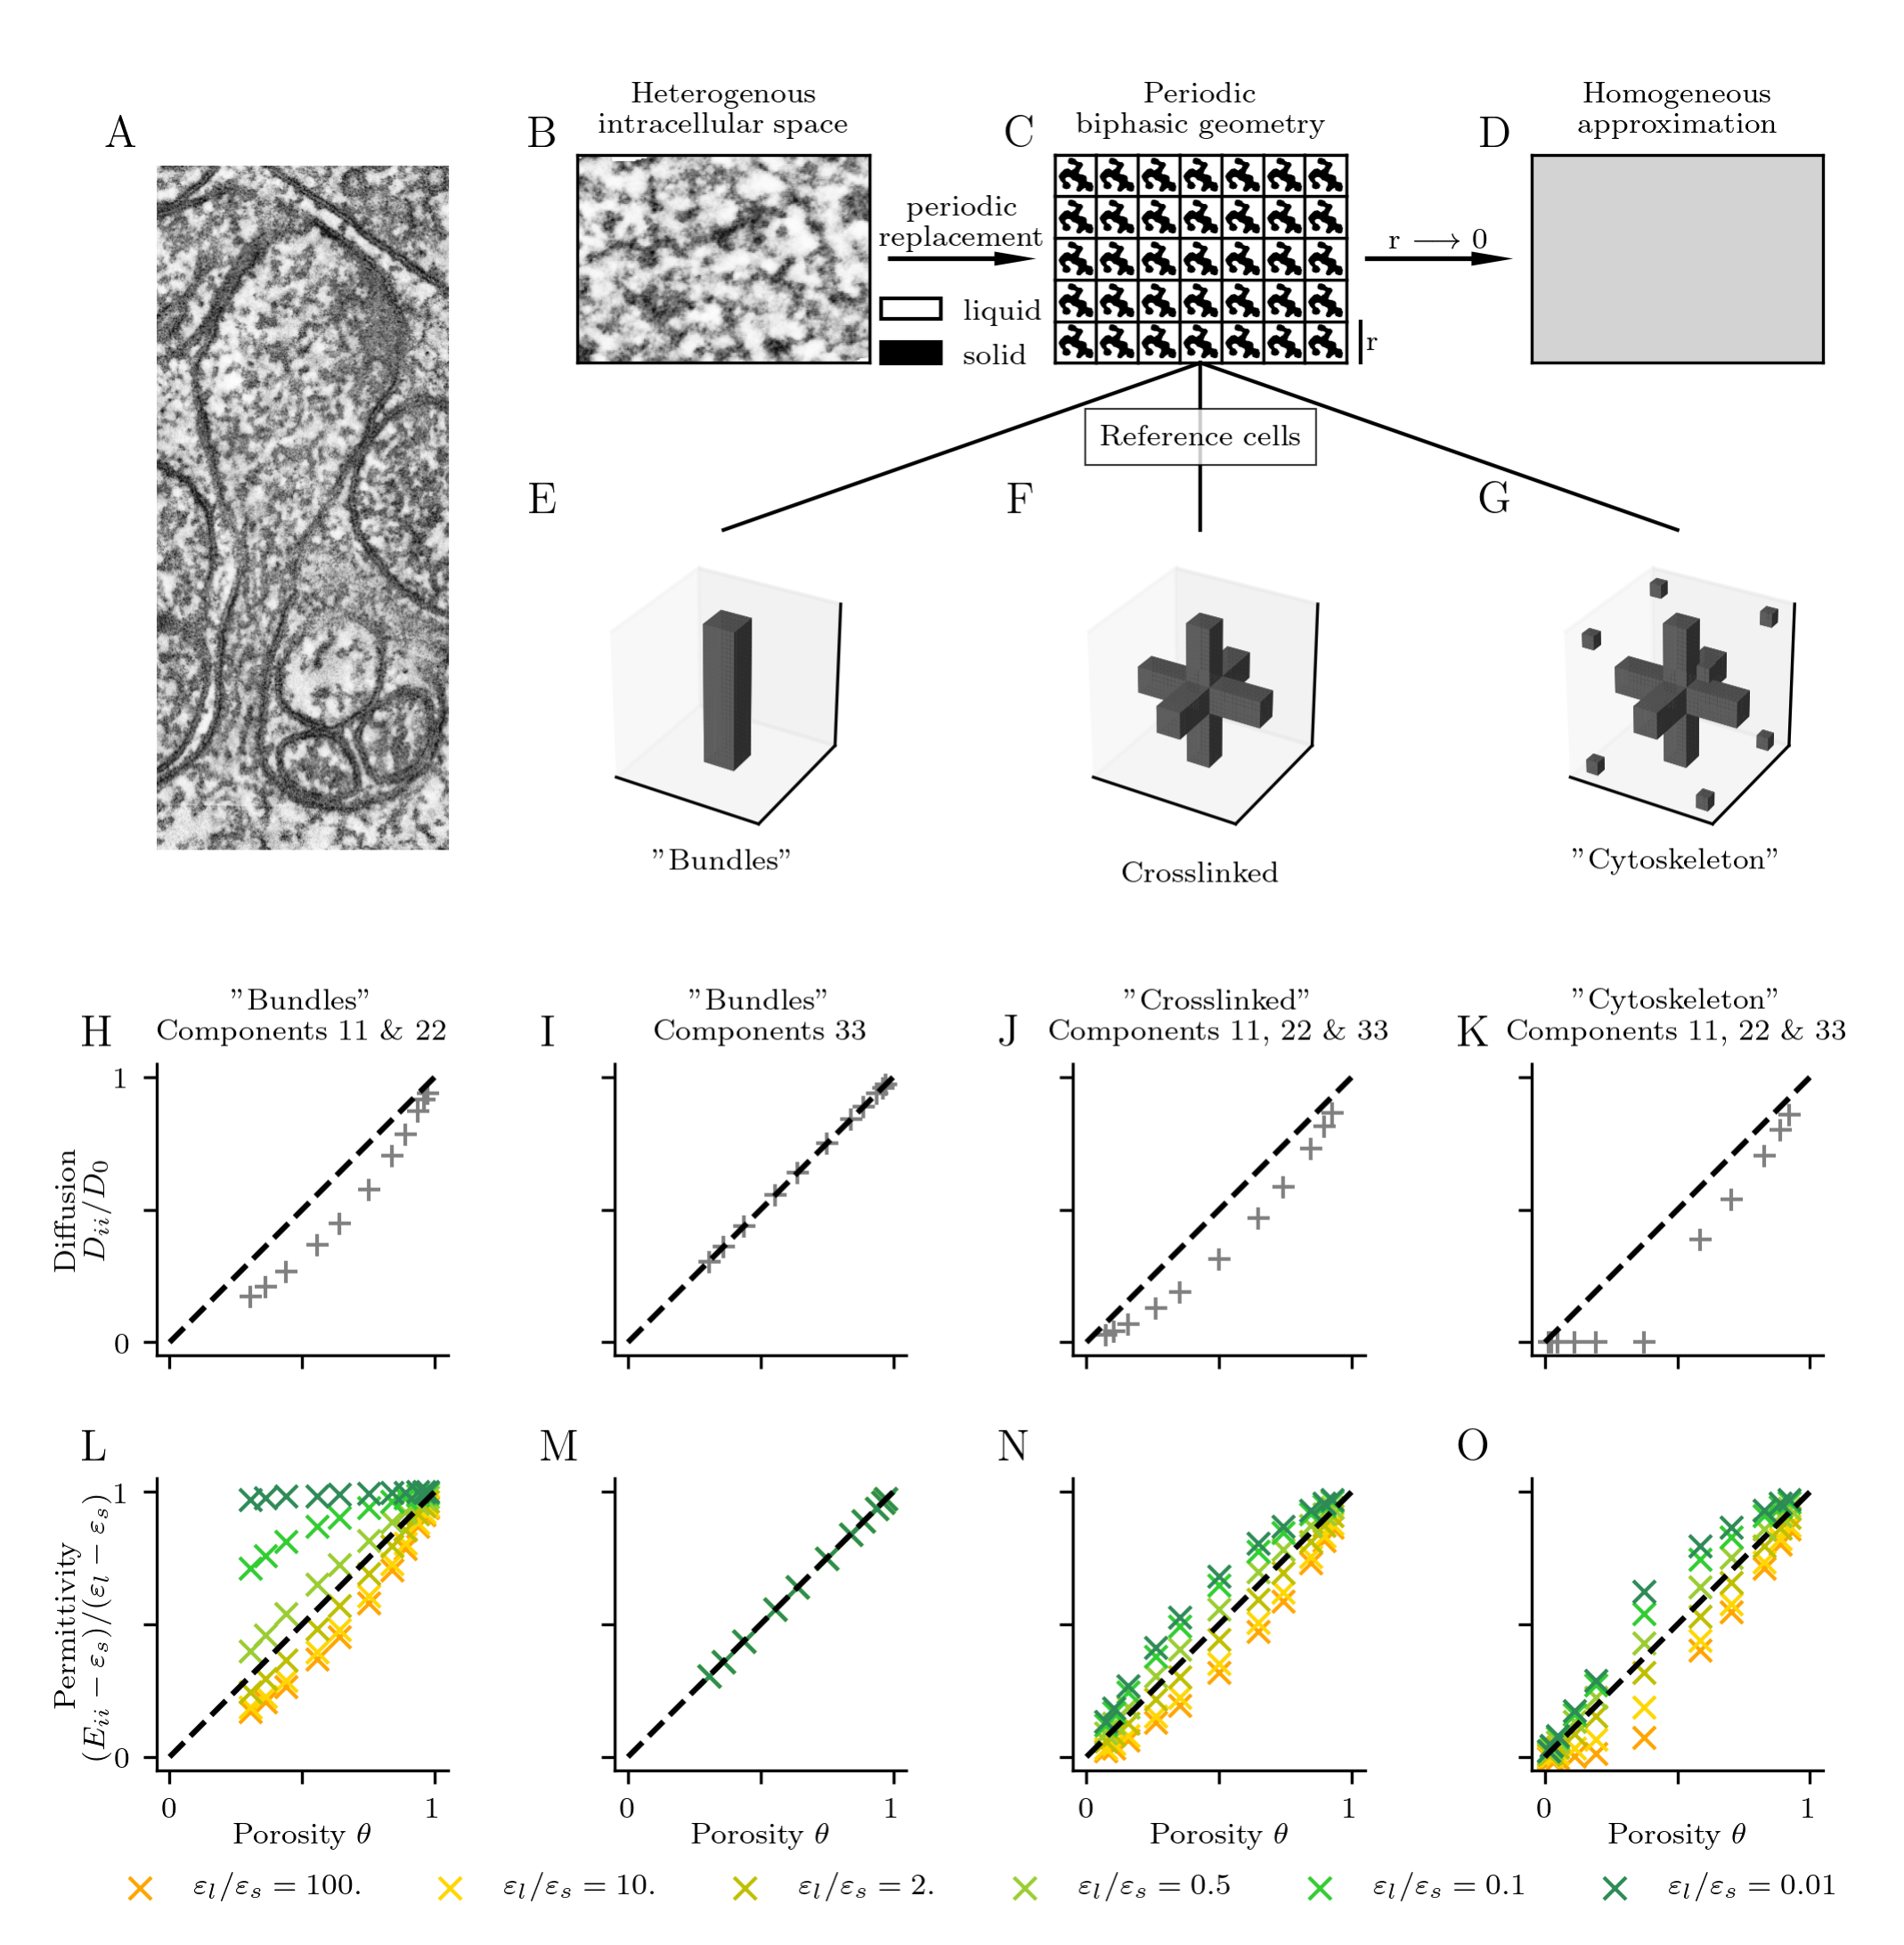

In [10]:
part1 = plt.imread('./../../../PaperSpineElectrodiffusion/figures/Figure01_part1.tif')
part2 = plt.imread('./../../../PaperSpineElectrodiffusion/figures/Figure01_part2.tif')


full_figure = np.concatenate((part1, part2), axis=0)
height, width, channels = np.shape(full_figure)
print(width, height)

fig_width = 17.6 / 2.54 # cm / (cm to inch)
fig_height = fig_width * height / width


fig = plt.figure(figsize=(fig_width, fig_height),dpi=300, )
ax = fig.add_axes([0,0,1,1])
ax.imshow(full_figure)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('./../../../PaperSpineElectrodiffusion/figures/Figure01.tif')
plt.savefig('./../../../PaperSpineElectrodiffusion/figures/homogenization/Figure1.png')
plt.show()

### Remark: Size of molecules
The size of the molecule will add to the porosity. For the geometry "Actin" the strong drop-off will happen at larger porosities for large molecules. If one measures diffusion from head to neck for different molecules with different sizes one can test the porosity under the assumption of a specific geomtry.

# Results:
Measurements of diffusion for sodium, potassium, chloride and calcium in pure water and intracellularly.
Predict diffusion based on measurements in free water and homogenization.

- https://corrosion-doctors.org/Corrosion-Kinetics/Overpotential-concentration.htm
- https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=860487


- Here: https://www.sciencedirect.com/science/article/pii/S0006349500768226#bib9 saline diffusion is reduced by square of tortuoisity


- Na+:
- K+:
- Cl-:
- Ca2+:


Outlook:
Diffusion will affect electrical resistance and permittivity the capacitance. The effect of the permittivity on the capacitance might only be relevant if double layer extend into intracellular and extracellular space. Otherwise only the membrane permittivity matters. 